In [1]:
from graphs import Graph
from distributed_planners import *
from exact_planners import CvxPlanner
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import nice, Time
from spectral import radius

c:\Users\oscar\Desktop\School\EE364P\graphs.py:152: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.C = nx.adjacency_matrix(self.nxg).todense()
c:\Users\oscar\miniconda3\lib\site-packages\numpy\linalg\linalg.py:671: RuntimeWarning: overflow encountered in matmul
  result = z if result is None else fmatmul(result, z)
100%|██████████| 120/120 [00:00<00:00, 166.16it/s]


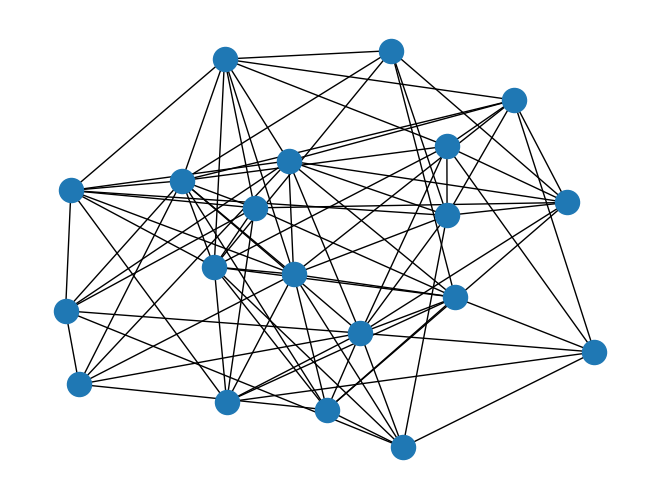

In [2]:
A = 20
M = 50
graph = Graph(A)
graph.random_graph(0.4)
graph.draw()
cvx_planner = CvxPlanner(A, M)

L_true = np.random.normal(0, 1, (A,M))
T_true = cvx_planner(L_true)

steps = 120
time = Time()
data = dict()

sym = False
mixes = {
    'eig_c' :       lambda: graph.eig_mix_cvxpy(sym=sym),
    'L2' :          lambda: graph.L2_mix(sym=sym),
    'metropolis' :  lambda: graph.metropolis_mix(),
    'eig_p' :      lambda: graph.eig_mix_pgd(sym=sym),
}

for key, mix in mixes.items():
    np.random.seed(0)
    L_averager = LAverager(A, M)
    C_averager = CAverager(A)
    mixer = PgdMixer(A)

    mix()
    C_true = graph.C
    W_true = graph.W

    L_error = np.zeros(steps)
    C_error = np.zeros(steps)
    W = np.zeros((A,A,A))
    for k in tqdm(range(steps)):
        W[:] = W_true
        L = L_averager(L_true, W)
        C = C_averager(C_true, W)
        L_error[k] = np.sum([ np.linalg.norm((L[a] - L_true).ravel()) for a in range(A) ])
        C_error[k] = np.sum([ np.linalg.norm((C[a] - C_true).ravel()) for a in range(A) ])
    
    data[key] = dict()
    data[key]['L'] = L_error
    data[key]['C'] = C_error
    data[key]['W'] = W_true
    data[key]['R'] = radius(W_true)

eig_c
L2
metropolis
eig_p


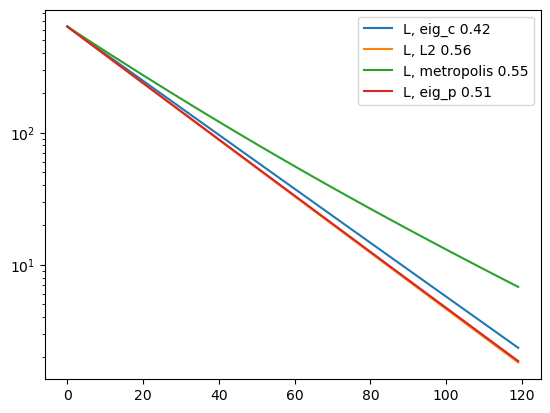

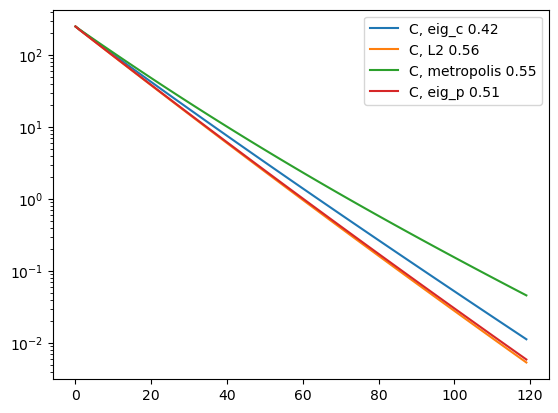

In [3]:
#print(nice(C_true))
for key in data:
    #print(nice(data[key]['W']))
    plt.figure(0)
    plt.plot(data[key]['L'], label = f'L, {key} {data[key]["R"]:.2f}')
    plt.legend()
    plt.semilogy()
    plt.figure(1)
    plt.plot(data[key]['C'], label = f'C, {key} {data[key]["R"]:.2f}')
    plt.legend()
    plt.semilogy()
    print(key)